# Roof Segmentation Challenge - Dida Technical Report


Technical Report for Dida
- Author: Antoine Hocquet
- Date: October 2025
- Repository (contains source code used here): [github.com/AntoineHocquet/dida-roof-seg](https://github.com/AntoineHocquet/dida-roof-seg)


## 1. Introduction
The goal of this task is to segment roof areas in 256x256 satellite images. The dataset consists of 30 images, of which 25 have corresponding masks used for training, and 5 images are provided for testing. The challenge lies in the limited dataset size, which makes the model prone to overfitting, and in the complex texture of roofs, often confused with roads or other bright structures.


### Model Design Choices
To mitigate these issues, I relied on an encoder-decoder architecture with skip connections, and a transfer learning approach for the encoder.
More precisely, we build a UNet-style model by concatenating:
- A ResNet encoder (options include the three popular variants `resnet18`, `resnet34`, `resnet50`). The encoder is pretrained on ImageNet (a convolutional NN from the torchvision library) to leverage transfer learning. It is possible to freeze the encoder's weights during the initial training epochs to further reduce overfitting.
- A lightweight UNet-style decoder, composed of up-sampling blocks. It is trained from scratch: the weights are initialed randomly. The head of the model is a 1x1 convolution followed by a sigmoid activation to produce a binary mask.

 To help detect small spatial details, we use the technique of *skip connections*. That is, the encoder's feature maps are concatenated to the decoder's upsampled maps at multiple scales (this approach is common in Deep Learning for Computer Vision, see [U-Net](https://arxiv.org/abs/1505.04597)). Intuitively, skip connections helps recover spatial details lost during downsampling, by reusing information drawn at each scale of the downsampling "pyramid" (these can be thought of as gradually finer details of the image).

### Code Base and OOP style
The code is organized in an object-oriented manner within the `dida-roof-seg` library, which includes modules for dataset handling, model definition, training, prediction, and visualization. The training and inference processes can be executed via command-line interface (CLI) commands.
To install the library from GitHub, use:
```bash
pip install git+https://github.com/AntoineHocquet/dida-roof-seg.git
```
Then import the library with the following command
```python
import dida_roofseg as drs
```

## 2. Methodology
### 2.1. Overall Pipeline
The project follows an object-oriented structure with six core classes:
- `RoofDataset`: (in `dataset.py`) Loads and preprocesses images/masks.
- `Encoder` (in `model.py`): ResNet backbone.
- `Decoder` (in `model.py`): UNet-style upsampling.
- `SegmentationModel` (in `model.py`): Glues encoder and decoder together to form the full model.
- `Trainer` (in `engine.py`): Handles training.
- ` Predictor` (in `engine.py`): Handles inference.

### 2.3. Loss and Metrics
Metrics used include BCEWithLogitsLoss, Dice coefficient, and IoU, which are standard for segmentation tasks. These provide a measure the overlap between predicted and ground truth masks.
A composite loss L = BCE + (1 - Dice) was also tested.

### 2.4. Training Details

The "best model" may depend on the metric used (Dice or IoU). Both are checkpointed during training, and we always keep the last checkpoint as well.

*Suggested parameters*:
- 512x512 inputs. (Original images have 256x256 pixels, however we find that doubling the size affects the results positively, maybe an effect of important downsampling for resnet encoders, or smallness of dataset?).
- batch size 4
- encoder learning rate: 1e-4
- decoder learning rate: 1e-3
- 100 epochs if GPU available (~5min on Colab), and 30 epochs otherwise (depending on hardware).
- Freeze encoder for first 10 epochs on GPU, 3 epochs otherwise.
- Encoder: resnet34 (other options: resnet18, resnet50)
- Validation split: 20%


## 3. Results
Final model performance (approx.):
- Validation Dice: ~0.85
- Validation IoU: ~0.73
Visual inspection on test images shows good roof segmentation with some errors for small or shadowed structures. Predictions are plotted below, in the "Numerical experiments" section of this notebook.

## 4. Discussion and Next Steps
Since the dataset is very small, further improvements could include data augmentation (flips, rotations, color jitter etc.). It would also be interesting to try k-fold validation to better estimate model performance. Experimenting with more advanced architectures (e.g., attention mechanisms) or loss functions (e.g., focal loss) could also be beneficial.

## 5. Conclusion
This notebook utilizes the concise deep learning library `dida-roof-seg` built by myself for the needs of the exercise. The pretrained resnet encoders "skip-connected" with the hands-on decoder seems to yield quite reasonable and interpretable results. Moreover, the OOP design hopefully gives a solid base for scaling to larger datasets.

# Numerical experiments

I hereby conduct numerical experiments using the GitHub repo "dida-roof-seg" (public, on my page), which was coded for the needs of the task.

## Repository Overview
### Structure of the main source code:

The core of the repository is the following set of modules (library `dida_roofseg`):

    ```bash
    .
    └── dida_roofseg
      ├── __init__.py
      ├── cli.py           # Cmd line interface
      ├── dataset.py       # main dataset class
      ├── engine.py        # Trainer, Predictor classes, etc.
      ├── io.py            # I/O utilities
      ├── model.py         # encoder, decoder, & model class
      ├── seed.py
      └── viz.py           # plotting utilities
    ```

### CLI - Available subcommands
- **`train`** - Train the roof segmentation model on the 25 labeled images.  
- **`predict`** - Generate roof mask predictions on the 5 unlabeled test images.  

### Parameters

Below is a table summarizing the main command-line arguments for training and prediction, as well as their defualt values (and descriptions):

| Argument | Default | Description |
|-----------|----------|-------------|
| `--data-dir` | `data/raw` | Directory containing input images and masks. |
| `--ckpt-dir` / `--ckpt-path` | `models/checkpoints/` | Path to save or load model checkpoints. |
| `--pred-dir` | `outputs/predictions` | Directory to save predicted masks. |
| `--epochs` | `20` | Number of training epochs. |
| `--batch-size` | `4` | Mini-batch size. |
| `--lr-encoder` | `1e-4` | Learning rate for encoder parameters. |
| `--lr-decoder` | `1e-3` | Learning rate for decoder parameters. |
| `--weight-decay` | `1e-4` | L2 regularization weight. |
| `--freeze-epochs` | `3` | Number of epochs with encoder frozen. |
| `--val-ratio` | `0.2` | Validation split ratio. |
| `--image-size` | `256` | Image resize dimension. |
| `--encoder` | `resnet18` | Encoder backbone (`resnet18`, `resnet34`, or `resnet50`). |
| `--threshold` | `0.5` | Binarization threshold for mask predictions. |
| `--seed` | `42` | Random seed for reproducibility. |
| `--device` | `cpu` | Device to use (`cpu` or `cuda`). |

---

### Installation

Since the repo is public, you can install it directly from GitHub using pip as follows.

In [1]:
# Install source code from repo
!pip install -U pip
!pip install "git+https://github.com/AntoineHocquet/dida-roof-seg.git@main"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/AntoineHocquet/dida-roof-seg.git (to revision main) to /tmp/pip-req-build-2s5106j2
  Running command git clone --filter=blob:none --quiet https://github.com/AntoineHocquet/dida-roof-seg.git /tmp/pip-req-build-2s5106j2
  Resolved https://github.com/AntoineHocquet/dida-roof-seg.git to commit 68d92ef5a0e5bcbfe87b8549101492cad53311c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dida-roofseg: filename=dida_roofseg-0.1.0-py3-none-any.whl size=21766 sha256=c64774b1b14840a66e079f30bb5ead1cf09b2d62bcaba1d47e4edb35bfbb00f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-tjass41l/wheels/fd/9f/a2/6eb3b899d92e66e6e46e7d3581b6fa933aae7429ef742a1

## Data

This notebook uses the data provided for the roof segmentation challenge (two folders, 55=30+25 PNG images total).
A popular way to load data on colab is fist to download it to your Drive, then mount the drive in colab. Here,we choose this appraoch for simplicity.

In [8]:
# access data on drive (the image data must lie on your drive for this to work)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Global variables and imports

We first import necessary libraries and set the device for computation (GPU if available, else CPU).

In [2]:
# torch-related & test GPU available
import torch
from torch.utils.data import DataLoader
GPU=(torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

In [37]:
# useful variables for the notebook
DATA_PATH="/content/drive/MyDrive/roofseg_data/raw" # Replace by the actual path to your version of the data
ENCODER_TYPE="resnet34"
RESIZE=516 # doubling the original size

if GPU[0]:
    DEVICE = 'cuda'
    EPOCHS=50  # 500 epochs on GPU
    FROZEN=10  # 30 epochs on GPU
else:
    DEVICE = 'cpu'
    EPOCHS=30   # 50 epochs on CPU
    FROZEN=3   # 30 epochs on CPU

print("Availability of GPU and device name:",GPU)
print("Device:",DEVICE)
print("Epochs:",EPOCHS)
print("Freeze epochs:",FROZEN)

Availability of GPU and device name: (True, 'Tesla T4')
Device: cuda
Epochs: 50
Freeze epochs: 10


## Architecture visualization

We can visualize the architecture of the model using `torchinfo.summary` as follows. At first we install `torchinfo` using pip

In [4]:
!pip install torchinfo
from torchinfo import summary # for schematic overview of nn

Next, we create a dummy model (i.e. with randomly initialized weights) and print its summary. In the dida_roofseg package, the model is built from the building blocks defined in `model.py` as follows.


In [5]:
from dida_roofseg.model import EncoderWrapper, DecoderUNetSmall, SegmentationModel

encoder = EncoderWrapper(name=ENCODER_TYPE, pretrained=False)
decoder = DecoderUNetSmall(encoder_channels=encoder.feature_channels)
model = SegmentationModel(encoder=encoder, decoder=decoder)
summary(model, input_size=(1,3, RESIZE, RESIZE))

Layer (type:depth-idx)                             Output Shape              Param #
SegmentationModel                                  [1, 1, 512, 512]          --
├─EncoderWrapper: 1-1                              [1, 64, 256, 256]         --
│    └─Sequential: 2-1                             [1, 64, 256, 256]         9,536
│    └─ResNet: 2-2                                 --                        513,000
│    │    └─Conv2d: 3-1                            [1, 64, 256, 256]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                              [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 128, 128]         --
│    │    └─Sequential: 3-5                        [1, 64, 128, 128]         221,952
│    │    └─Sequential: 3-6                        [1, 128, 64, 64]          1,116,416
│    │    └─Sequential: 3-7                        [1, 256, 32, 32]          6,822,400
│   

As already discussed in the report, the model architecture is simple and straightforward.
Here the encoder contains a ResNet backbone with 34 layers, and the decoder is a UNet-style architecture with skip connections.

## Training

We run the command line interface of `dida_roofseg` to perform training.
For that purpose, we use a shell command as below.

In [38]:
# training loop with specified parameters

print("\nStarting training...\n", "Data path:", DATA_PATH, "\nEncoder type:", ENCODER_TYPE, "\nResize:", RESIZE, "\nDevice:", DEVICE)
print("-"*75)
!dida-roofseg train --data-dir $DATA_PATH --device $DEVICE --epochs $EPOCHS --freeze-epochs $FROZEN --encoder $ENCODER_TYPE --image-size $RESIZE



Starting training...
 Data path: /content/drive/MyDrive/roofseg_data/raw 
Encoder type: resnet34 
Resize: 1024 
Device: cuda
---------------------------------------------------------------------------
Epoch 1 [FROZEN]: 100% 5/5 [00:03<00:00,  1.27it/s]
Epoch 1/50 | train_loss=1.3281 | val_loss=1.4073 | val_iou=0.4179 | val_dice=0.5893
  ✔ Saved new best checkpoint: models/checkpoints/best_iou.pth (IoU=0.4179)
  ✔ Saved new best checkpoint: models/checkpoints/best_dice.pth (Dice=0.5893)
Epoch 2 [FROZEN]: 100% 5/5 [00:03<00:00,  1.59it/s]
Epoch 2/50 | train_loss=1.0201 | val_loss=11.0239 | val_iou=0.1659 | val_dice=0.2840
Epoch 3 [FROZEN]: 100% 5/5 [00:03<00:00,  1.64it/s]
Epoch 3/50 | train_loss=0.8997 | val_loss=3.5498 | val_iou=0.2270 | val_dice=0.3687
Epoch 4 [FROZEN]: 100% 5/5 [00:03<00:00,  1.64it/s]
Epoch 4/50 | train_loss=0.8157 | val_loss=2.2881 | val_iou=0.2962 | val_dice=0.4570
Epoch 5 [FROZEN]: 100% 5/5 [00:03<00:00,  1.62it/s]
Epoch 5/50 | train_loss=0.7382 | val_loss=1.137

We now load the learning history to check again what the best scores are.

In [40]:
import json
history=json.load(open("/content/models/checkpoints/history.json"))

# Compute min and argmin of train loss
min_train_loss = min(history["train_loss"])
argmin_train_loss = history["train_loss"].index(min_train_loss)

print("Best train_loss (lowest):", min_train_loss)
print("Epoch:", argmin_train_loss)

# compute max and argmax of history["val_iou"]
max_val_iou = max(history["val_iou"])
argmin_val_iou = history["val_iou"].index(max_val_iou)

print("Best val_iou (highest):", max_val_iou)
print("Epoch:", argmin_val_iou)

# compute max and argmax of history["val_dice"]
max_val_iou = max(history["val_dice"])
argmin_val_iou = history["val_dice"].index(max_val_iou)

print("Best val_iou (highest):", max_val_iou)
print("Epoch:", argmin_val_iou)


Best train_loss (lowest): 0.11868651658296585
Epoch: 45
Best val_iou (highest): 0.7094833353208829
Epoch: 28
Best val_iou (highest): 0.8299573325837603
Epoch: 28


We can also plot the learning curves.

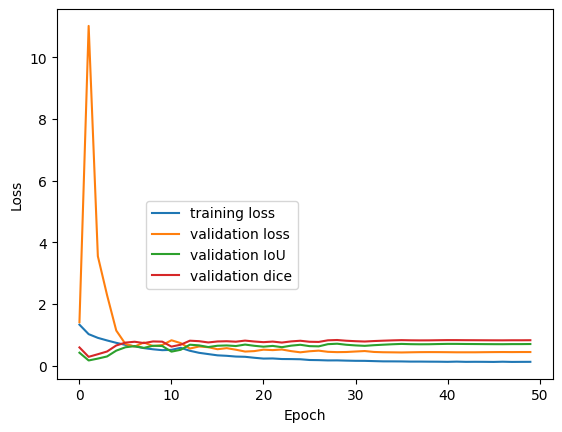

In [41]:

from dida_roofseg.viz import plot_learning_curves

plot_learning_curves(history)


## Model evaluation

Now that the model is trained, we can visualize some predictions, first on the validation set (same as training here), and then on the test set (the 5 pictures provided without masks).
To evaluate the model, we first import the `RoofDataset` class from `dataset.py`.

We also use the `discover_pairs` function from `io.py` to find the image paths and mask paths automatically, and thereby create the validation and test datasets.

Finally, we use the `Predictor` class from `engine.py` to generate predictions on the validation and test sets.

In [20]:
from dida_roofseg.dataset import RoofDataset
from dida_roofseg.io import discover_pairs
from dida_roofseg.engine import Predictor

In [42]:
# We first use the `io` module to find images paths:
# - labeled_images: list of image paths for train+val
# - mask_map: dict mapping image stem to mask path (straightforward here since images and masks have same names)
# - test_images: list of image paths for test set
labeled_images, mask_map, test_images = discover_pairs(DATA_PATH)

# create validation datasets & dataloader
# we only use (labeled images here)
val_ds= RoofDataset(mode="val", image_paths=labeled_images, mask_dir_map=mask_map, image_size=RESIZE)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# Build the model trained above
encoder = EncoderWrapper(name=ENCODER_TYPE, pretrained=False)
decoder = DecoderUNetSmall(encoder_channels=encoder.feature_channels)
model = SegmentationModel(encoder=encoder, decoder=decoder)

# Instantiate a predictor
# (choose between iou, dice or last checkpoint)
CKPT_PATH="models/checkpoints/best_iou.pth" # or best_dice.pth, or last.pth
predictor = Predictor(model=model, ckpt_path=CKPT_PATH)

### Visualization on a batch of images

To visualize the model's predictions on a batch of images, we use the `plot_batch` function from `viz.py`.
Those images are taken from the training set and thus have ground truth masks. We can then judge intuitively if the model's predictions are good or not.

In [22]:
from dida_roofseg.viz import plot_batch

Saved plot to comp_plot.png


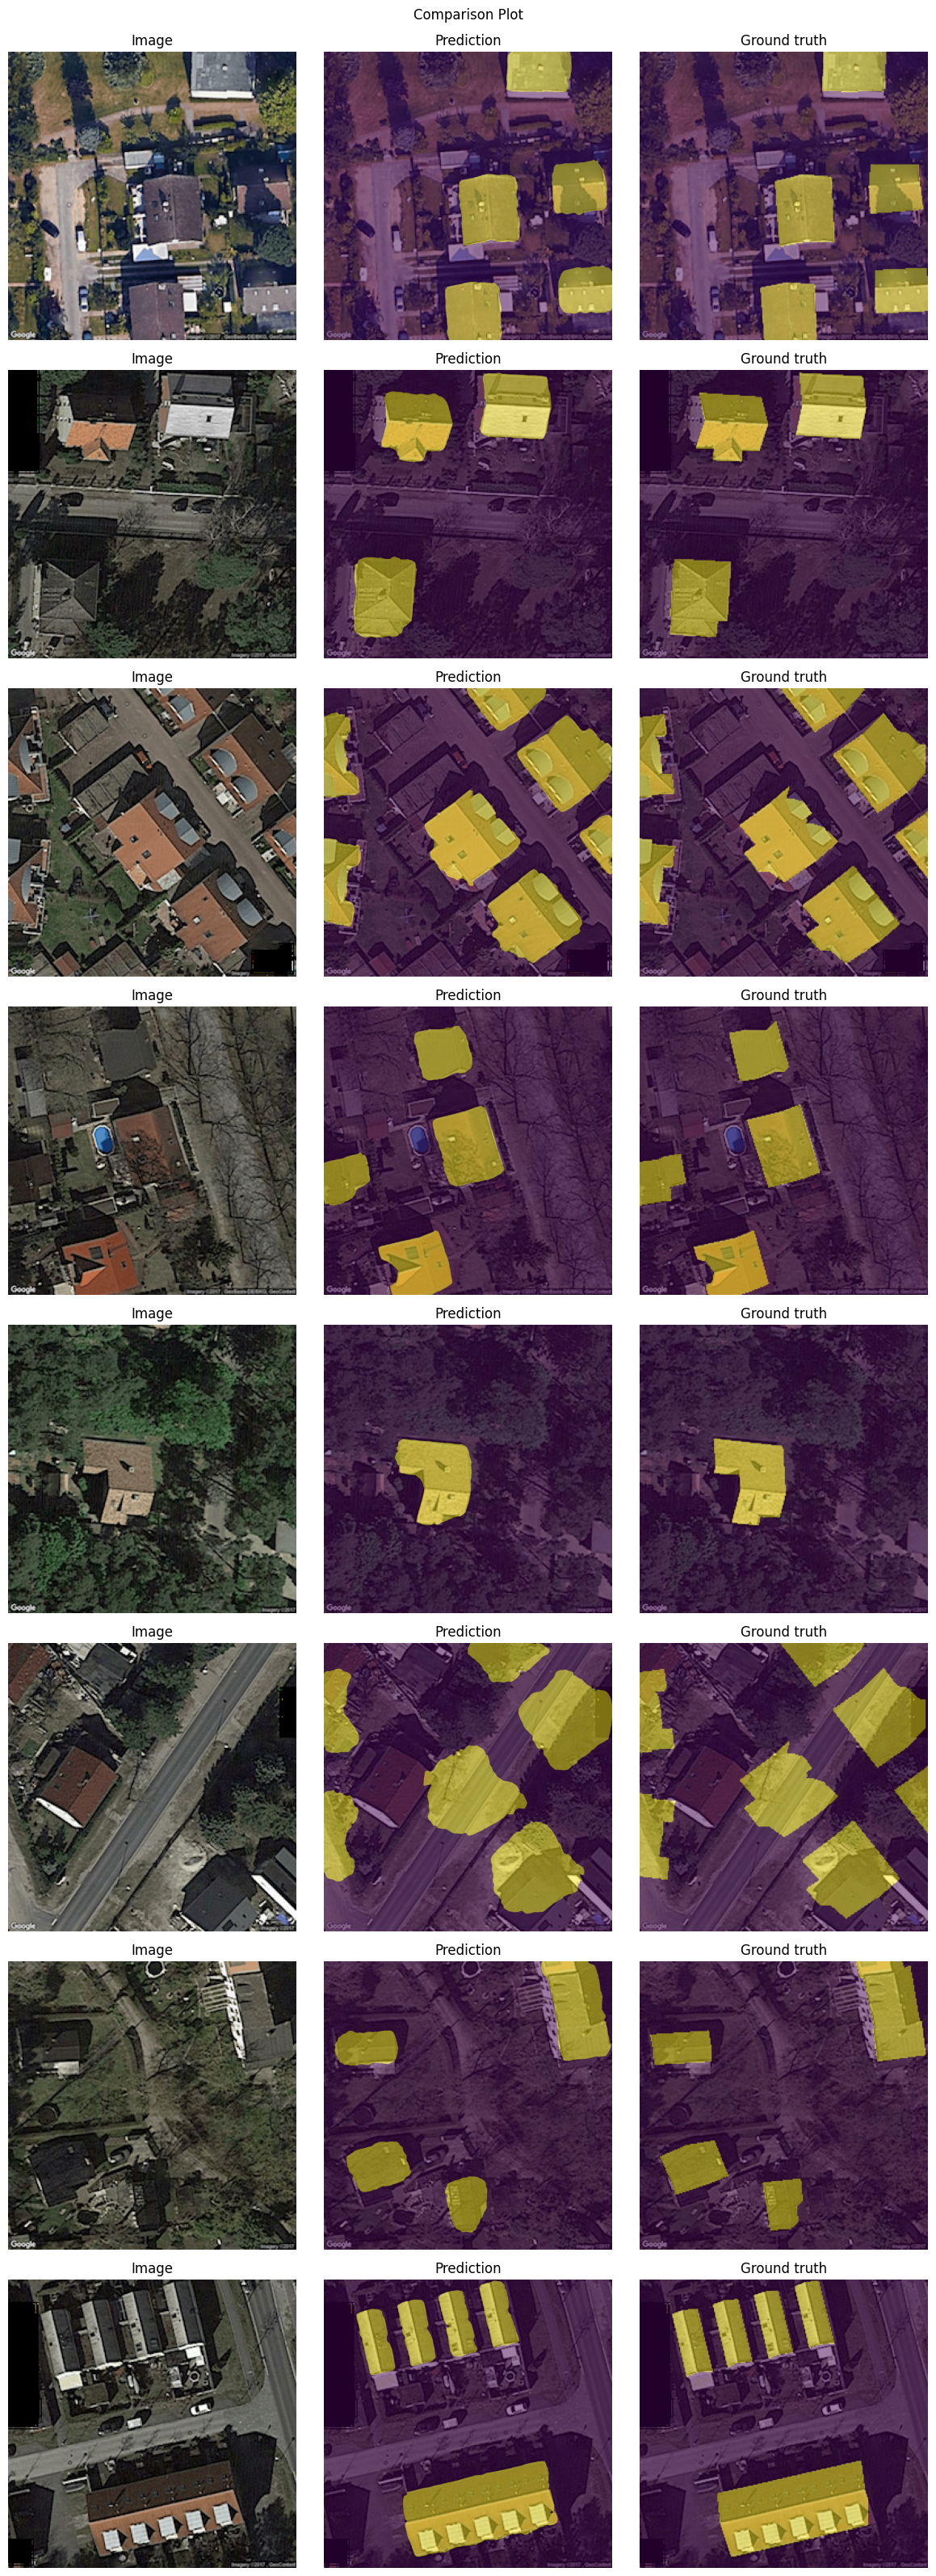

In [43]:
# create a batch of IMG_BATCH<=25 images and plot it
IMG_BATCH=8
imgs_list=[]
masks_list=[]
for i,(imgs_batch,masks_batch) in enumerate(val_loader):
    imgs_list.append(imgs_batch)
    masks_list.append(masks_batch)
    if i>=IMG_BATCH-1:
        break
imgs=torch.cat(imgs_list,dim=0)
masks=torch.cat(masks_list,dim=0)

# use the predictor instantiated before to make predictions
preds=predictor.predict_batch(imgs)

# Plot 3 graphs -- image, predicted mask & mask -- for the full batch (25 images)
plot_batch(
    imgs,
    preds,
    masks,
    max_n=IMG_BATCH,
    title="Comparison Plot",
    save_path="comp_plot.png",
    show=True,
    overlay_alpha=0.5,
    mean=(0.485, 0.456, 0.406), # for denormalization
    std=(0.229, 0.224, 0.225) # for denormalization
)

## Test on the 5 test imgs

Next, we test our model on the 5 test images provided.

Saved plot to test_plot.png


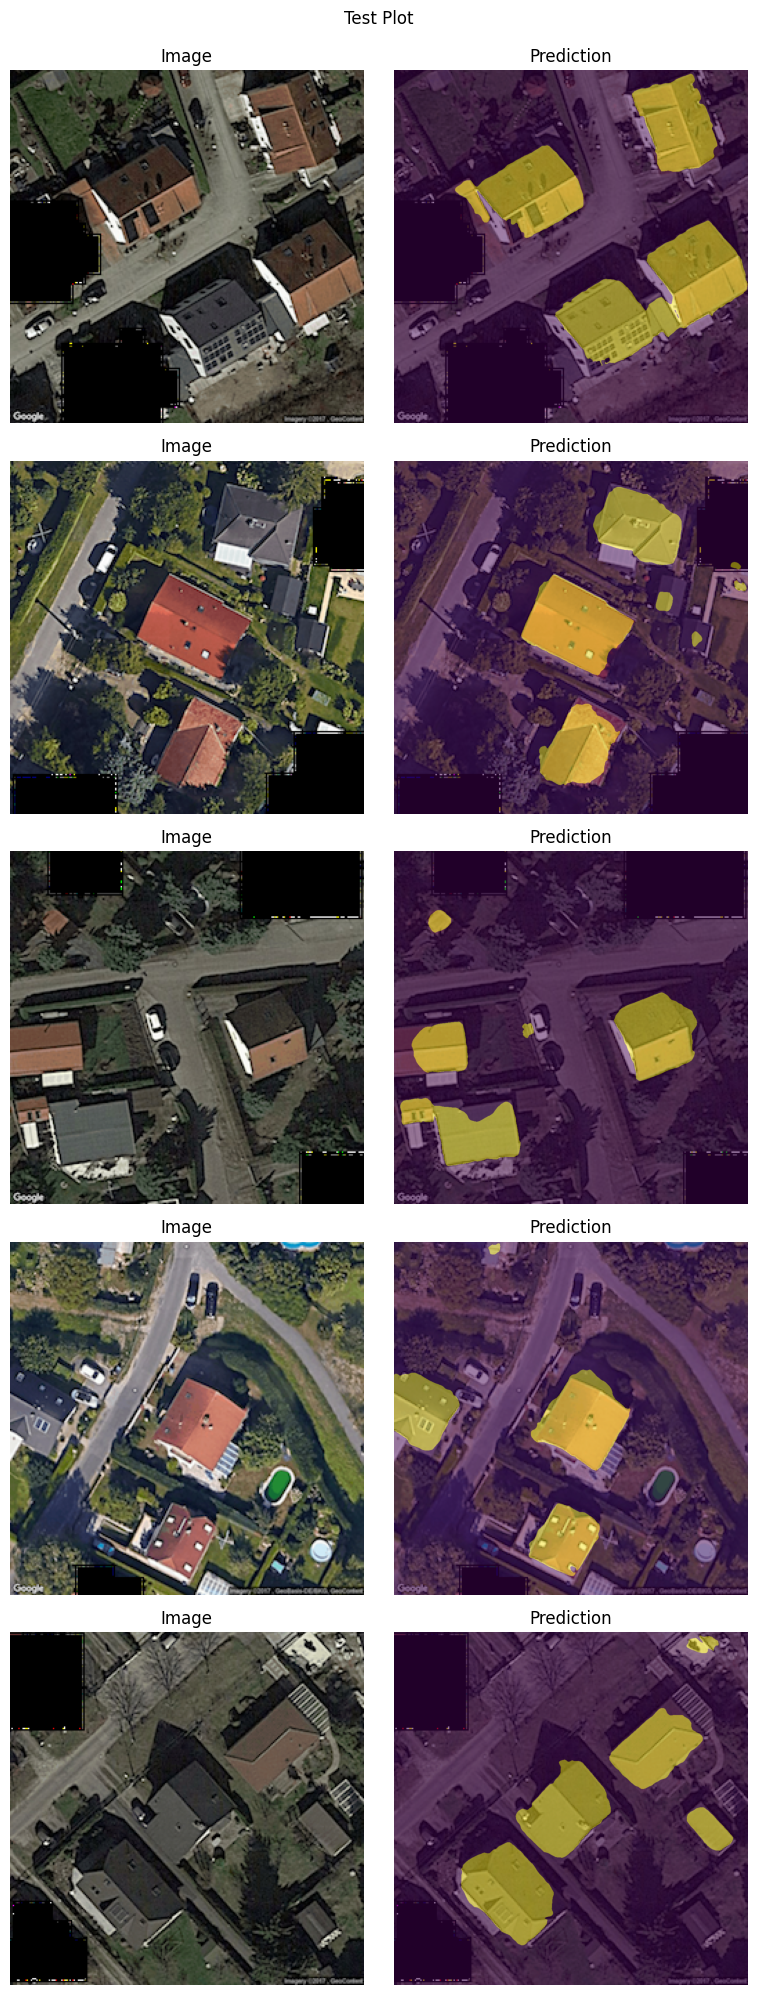

In [44]:
# first create test dataset & dataloader (image_paths changed for `test_images` below)
test_ds = RoofDataset(mode="test", image_paths=test_images, image_size=RESIZE)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# Look at the full batch of 5 images
imgs_list=[]
for i,(imgs_batch,_) in enumerate(test_loader):
    imgs_list.append(imgs_batch)
    if i>=4:
        break
imgs=torch.cat(imgs_list,dim=0)
preds=predictor.predict_batch(imgs)

# visualize test images and predictions
plot_batch(
    imgs,
    preds,
    max_n=5,
    title="Test Plot",
    save_path="test_plot.png",
    show=True,
    overlay_alpha=0.5,
    mean=(0.485, 0.456, 0.406), # for denormalization
    std=(0.229, 0.224, 0.225) # for denormalization
)